#<font color=fbb03b>LSTMモデルを使用

#<font color=fbb03b>事前準備

##ライブラリのインポート

In [ ]:
# Install required dependencies
!apt-get install -y build-essential
!apt-get install -y wget

# Download and install TA-Lib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xvzf ta-lib-0.4.0-src.tar.gz
!cd ta-lib && ./configure --prefix=/usr && make && make install && cd ..

# Install the Python wrapper for TA-Lib
!pip install TA-Lib

!pip install yfinance
!pip install bayesian-optimization

In [ ]:
import numpy as np
from sklearn.metrics import r2_score
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np
import yfinance as yf
yf.pdr_override()
from datetime import datetime
import talib
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.regularizers import l2
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

## 【補足】TA-Libについて

TA-Lib（Technical Analysis Library）は、テクニカル分析を行うためのPython向けのライブラリです。

主な機能としては以下があります：

1. **テクニカル指標の計算**: TA-Libは、さまざまなテクニカル指標を計算するための関数を提供しています。例えば、移動平均線（Simple Moving Average, SMA）、指数加重移動平均（Exponential Moving Average, EMA）、相対力指数（Relative Strength Index, RSI）、ボリンジャーバンド（Bollinger Bands）などがあります。

2. **パターン認識**: チャートパターンの認識にも使用できます。例えば、ハンマーや逆ハンマー、三尊天井や三尊底などのパターンを認識するための機能があります。

3. **トレンドの特定**: 移動平均線やMACD（Moving Average Convergence Divergence）などを使用してトレンドの特定や転換点の検出が可能です。

4. **ボリュームの解析**: ボリューム指標を使用して、出来高や取引量の解析を行うことができます。

5. **統計的解析**: ヒストリカルデータを使用して統計的な解析を行う機能もあります。例えば、平均値、標準偏差、ボラティリティなどを計算できます。

※TA-Libは金融分野で広く利用されており、テクニカルアナリストやアルゴリズムトレーダーなどがチャート分析や取引戦略の開発に活用しています。

#<font color=fbb03b>1. LSTMを用いた株価分析①

##<font color=fbb03b>1.1 データ準備

In [ ]:
# Google(アルファベット)のOHLCVを取得
s_target = 'GOOG'
df = pdr.get_data_yahoo(s_target, start='2014-01-01', end=datetime.now())
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,27.782366,27.839401,27.603037,27.724083,27.692570,73129082
2014-01-03,27.770908,27.818977,27.520098,27.521841,27.490559,66917888
2014-01-06,27.721344,27.867046,27.557707,27.828691,27.797060,71037271
2014-01-07,28.019974,28.385853,27.924334,28.365179,28.332937,102486711
2014-01-08,28.543015,28.575891,28.226450,28.424210,28.391901,90036218


###<font color=fbb03b>データを可視化して確認

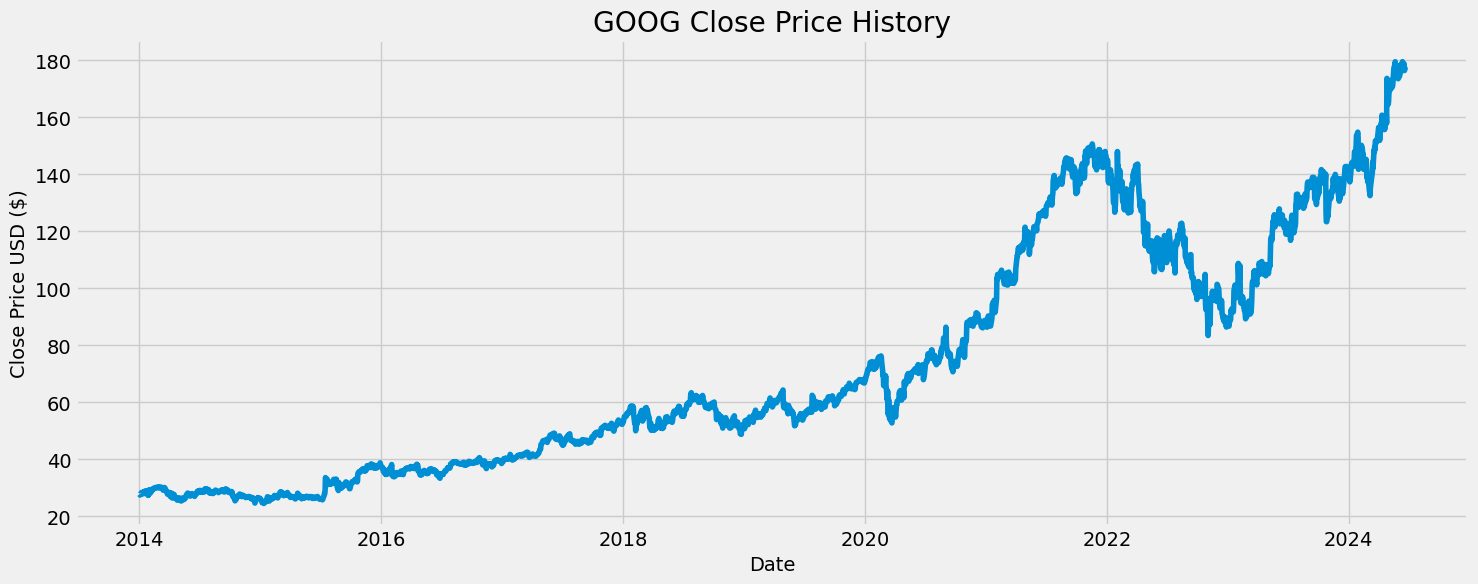

In [ ]:
# 株価データをグラフで確認
plt.figure(figsize=(16,6))
plt.title(s_target + ' Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.show()

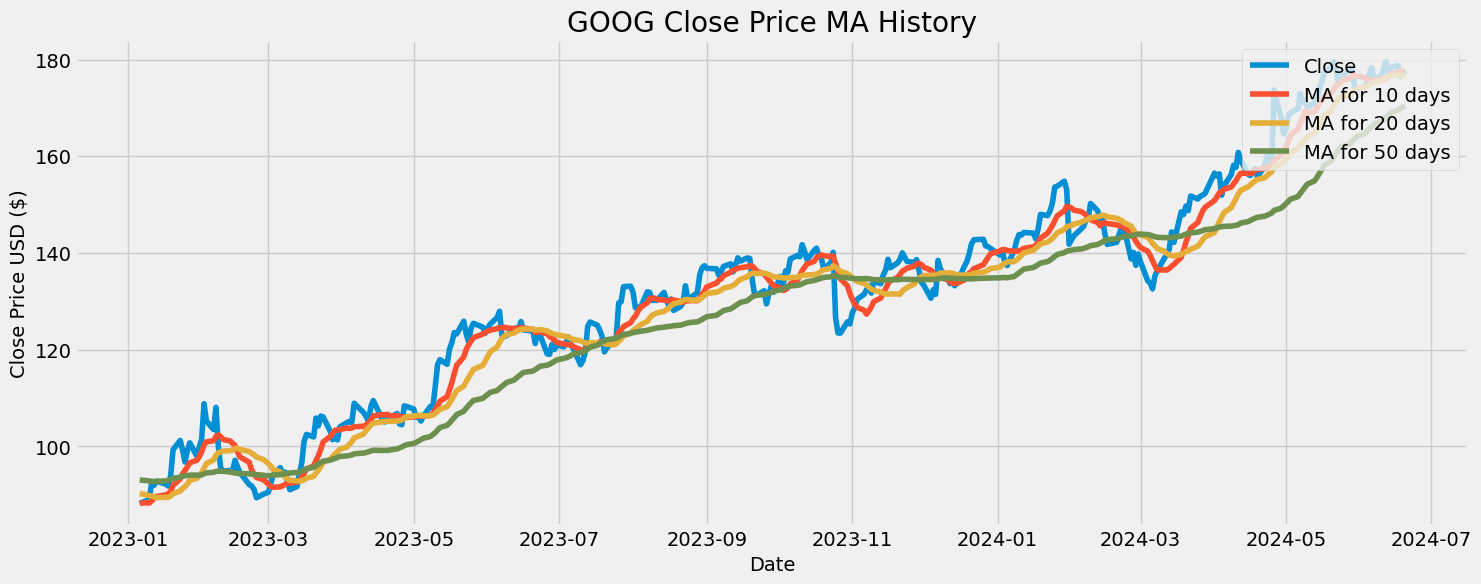

In [ ]:
# 移動平均を追加
'''
rolling関数で指定期間を取り出してmeanで平均を取るだけで移動平均の数字データ作成可能。
10日、20日、50日の終値に対する移動平均を作成。
グラフでは全期間を表示するとMAが分かりにくいので直近1年365日分を表示。
'''
ma_day = [10, 20, 50]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] = df['Adj Close'].rolling(ma).mean()

plt.figure(figsize=(16,6))
plt.title(s_target + ' Close Price MA History')
plt.plot(df['Close'][-365:])
plt.plot(df['MA for 10 days'][-365:])
plt.plot(df['MA for 20 days'][-365:])
plt.plot(df['MA for 50 days'][-365:])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.legend(['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days'], loc='upper right')
plt.show()

###<font color=fbb03b>LSTMのためのデータの準備

In [ ]:
# LSTMのためのデータを準備

# 終値を特徴量として使用
data = df[['Close', ]]

# NaNを含む行を削除
data = data.dropna()

dataset = data.values

# データを0〜1の範囲に正規化
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.020413  ],
       [0.01910821],
       [0.02108789],
       ...,
       [0.99496775],
       [0.97993547],
       [0.98806457]])

##<font color=fbb03b>1.2 LSTMモデルの構築

In [ ]:
# LSTMトレーニングデータを準備
'''
window sizeを365に設定した。
過去365日分のデータを特徴量として利用して次の366日目を学習するという意味。
その期間だけずれた配列を作り、numpy arrayに変換する。
'''

# 全体の80%をトレーニングデータとして扱う
training_data_len = int(np.ceil( len(dataset) * .8 ))

# どれくらいの期間をもとに予測するか
window_size = 365

train_data = scaled_data[0:int(training_data_len), :]

# train_dataをx_trainとy_trainに分ける
x_train, y_train = [], []
for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, :])
    y_train.append(train_data[i, 0])  # Close priceを予測

# numpy arrayに変換
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

In [ ]:
# LSTMモデルの構築
'''
参考：「mwitiderrick/stockprice」
※LSTMを用いて株価を予測するにはどれくらい学習すべきかを書いた論文「Stock Market Prediction Using LSTM Recurrent Neural Network」に近い実装となっていそうだから。

LSTMの層にそれぞれDropoutが接続されているので、特徴を見つけながら一部は忘れて強くなっていくイメージ。
最適化アルゴリズムにadam、損失関数にはMSE（平均二乗誤差）を指定した。
これを実行すると予測値と正解値を計算して、損失(loss)が最小になるように学習。
しばらく眺めているとlossの値が小さくなっていくはず。
'''
model = Sequential()
model.add(LSTM(units=100,return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# モデルのコンパイルとトレーニング
# validation_splitを指定してモデルを学習
model.compile(optimizer='adam', loss='mean_squared_error')
# Set the validation split. 20% of the training data will be used for validation
validation_split = 0.2
history = model.fit(x_train, y_train, batch_size=32, epochs=70, validation_split=validation_split)

# トレーニングと検証の損失を取得
train_loss = history.history['loss']
val_loss = history.history['val_loss']  # Now you should have validation loss

# エポックごとの損失をプロット
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/70
44/44 [==============================] - 66s 1s/step - loss: 0.0038 - val_loss: 0.0019
Epoch 2/70
44/44 [==============================] - 53s 1s/step - loss: 6.7190e-04 - val_loss: 0.0016
Epoch 3/70
44/44 [==============================] - 57s 1s/step - loss: 5.7726e-04 - val_loss: 0.0025
Epoch 4/70
44/44 [==============================] - 53s 1s/step - loss: 5.0599e-04 - val_loss: 0.0018
Epoch 5/70
44/44 [==============================] - 52s 1s/step - loss: 4.6453e-04 - val_loss: 0.0034
Epoch 6/70
44/44 [==============================] - 54s 1s/step - loss: 5.3497e-04 - val_loss: 0.0014
Epoch 7/70
44/44 [==============================] - 55s 1s/step - loss: 5.3060e-04 - val_loss: 0.0012
Epoch 8/70
44/44 [==============================] - 53s 1s/step - loss: 4.5034e-04 - val_loss: 0.0012
Epoch 9/70
44/44 [==============================] - 52s 1s/step - loss: 3.9840e-04 - val_loss: 0.0019
Epoch 10/70
44/44 [==============================] - 52s 1s/step - loss: 4.4299e-04 - 

###<font color=fbb03b>モデルサマリー

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 365, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 365, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 365, 100)          80400     
                                                                 
 dropout_1 (Dropout)         (None, 365, 100)          0         
                                                                 
 lstm_2 (LSTM)               (None, 365, 100)          80400     
                                                                 
 dropout_2 (Dropout)         (None, 365, 100)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               8

#### モデルサマリーについての解説

この `model.summary()` の出力は、Kerasのモデルサマリーです。これは、モデルの各層とそのパラメータ数、出力形状などの情報を示しています。以下に解説します：

- **Layer (type)**: レイヤーのタイプとその名前が表示されます。例えば、LSTM層、Dropout層、Dense層などがあります。

- **Output Shape**: 各レイヤーの出力形状が示されます。たとえば、`(None, 365, 50)` は出力が `(サンプル数, 時系列長, ユニット数)` であることを示します。

※例えば、(None, 365, 50) の場合、サンプル数が可変で、時系列長が365であり、ユニット数が50であることを示しています。この出力形状はLSTM層などでよく見られる形式で、時系列データの処理に適しています。

- **Param #**: 各レイヤーのパラメータ数です。LSTMやDenseなどの層では、この数が重要です。この数はモデルが学習する重みとバイアスの数を表しています。

- **Total params**: 全体のパラメータ数です。ここでは `71051` です。これは全ての層のパラメータ数の合計です。

- **Trainable params**: 学習可能なパラメータ数です。これはモデルが学習中に更新されるパラメータの数を示します。

- **Non-trainable params**: 学習不可のパラメータ数です。たとえば、BatchNormalizationの平均や分散などが含まれます。

このサマリーは、モデルを構築した際の構造やパラメータ数を把握するのに役立ちます。特に大規模なモデルや複雑なニューラルネットワークを扱う際に重要な情報です。

**【補足】**

Layer (type)とOutput Shapeそれぞれの用語を解説します。

1. **Layer (type)**:
   - **LSTM層 (Long Short-Term Memory)**: LSTMは再帰型ニューラルネットワーク（RNN）の一種で、時系列データや系列データを扱うのに適した層です。LSTMは過去の情報を記憶するメカニズムを持ち、長期的な依存関係を学習することができます。主に時系列データの予測や自然言語処理などで使われます。
   - **Dropout層**: ドロップアウトは過学習（overfitting）を防ぐための手法の一つで、ニューラルネットワークの学習中にランダムに一部のユニットを無効化することで、モデルの汎化能力を向上させます。
   - **Dense層**: Dense（またはFully Connected）層は、ニューラルネットワークの基本的な層の一つであり、全結合されたニューロンの層です。つまり、前の層のすべてのユニットが次の層のすべてのユニットに接続されます。

2. **Output Shape**:
   - **サンプル数**: モデルが一度に処理するデータのサンプル数です。通常はバッチサイズとも呼ばれます。例えば、バッチサイズが64だとすると、64個のデータサンプルがモデルに入力されます。
   - **時系列長**: 時系列データの長さを示します。時系列データでは、過去の情報を利用するため、一度に何個の時系列データを扱うかが重要です。例えば、365日のデータを一度に処理する場合、時系列長は365になります。
   - **ユニット数**: 各層のニューロン（ユニット）の数です。つまり、ユニット数は、ニューラルネットワークの各層におけるノード（ニューロン）の数を指します。これは、モデルがその層でどれだけの情報を表現できるかを決定する重要な要素の一つです。Dense層の場合は、その層のユニット数が示されます。LSTM層の場合は、隠れ層のユニット数が示されます。

###補足説明（ハイパーパラメータについて）

**【深層学習LSTMモデルにおけるハイパーパラメータの調整とモデルパフォーマンスの関係】**

- 深層学習LSTMモデルにおけるハイパーパラメータ をグリッドサーチやベイズ最適化などの手法 を用いて調整 することで、モデルのパフォーマンス を向上 させる可能性が高いです。

- ハイパーパラメータは、モデル の学習 や予測 に影響を与える重要な設定値です。

- 適切なハイパーパラメータを選択することで、モデルの精度を向上させたり、学習を高速化したりすることが可能になります。

- グリッドサーチとベイズ最適化は、ハイパーパラメータを自動的に調整する手法です。

- グリッドサーチ: 指定された範囲 内で全ての 組み合わせ を試 して、最良 の設定 を見つけます。

- ベイズ最適化: 確率的 なモデル を用いて、効率的 に最良 の設定 を探索 します。

これらの手法を利用することで、手動でハイパーパラメータを調整するよりも効率的に最良の設定を見つけることができます。

**【代表的なハイパーパラメータと説明】**

以下 に、LSTMモデル でよく 使用 される代表的なハイパーパラメータ と、それぞれ の説明 を簡潔 に示 します。

1.**学習率**:

- 説明: モデルのパラメータを更新 する際のステップ幅 を決定 する値 です。

- 影響: 学習率が高 ほど、学習 が速 くなりますが、過学習 のリスク が高くなります。

- 適切な値: 0.001～0.01

2.**バッチサイズ**:

- 説明: モデルのパラメータを更新 する際のデータ数 を決定 する値 です。
- 影響: バッチサイズが大 ほど、学習 が速 くなりますが、メモリ使用量 が増加 します**。
- 適切な値: 32～128

3.**エポック数**:

- 説明: モデルを学習 する回数 を決定 する値 です。

- 影響: エポック数が多 ほど、モデル は学習 を進め ますが、過学習 のリスク が高くなります。

- 適切な値: データ量やモデルの複雑さに依存するため、試行錯誤 が必要

4.**ドロップアウト率**:

- 説明: ニューラルネットワーク の一部のニューロン をランダム に非活性化 する確率 を決定 する値 です。

- 影響: ドロップアウト率が高 ほど、過学習 を防止 する効果 が高くなります が、モデル の精度 が低下 する可能性 があります。

- 適切な値: 0.2～0.5

【まとめ】

深層学習LSTMモデルにおけるハイパーパラメータは、モデルのパフォーマンスに大きな影響を与えます。グリッドサーチやベイズ最適化などの手法を利用することで、効率的に最良の設定を見つけることができます。

上記で説明したハイパーパラメータを理解し、適切な値に設定することで、モデルの精度を向上させることができます。

##<font color=fbb03b>1.3 LSTMモデルの検証

In [ ]:
'''
# testdataでLSTMを検証する
作成したモデルをtestdataで検証。
残した20%のデータでtestdataを作成し、traindataの時と同様にnumpy arrayに変換する。
'''

# テストデータを作成
test_data = scaled_data[training_data_len - window_size:, :]

x_test = []
y_test = dataset[training_data_len:, 0]
for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, :])

# numpy arrayに変換
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

In [ ]:
'''
予測（predict）を実行してpredictionsに入力する。
最初に0〜1の値に正規化していたので、実際の価格に戻す。
簡単な確認のために、RMSE(二乗平均平方根誤差)と、R2(決定係数)という値をみる。
※RMSEは0に近いほど予測精度が高く、R2は1に近いほど予測精度が高くなる。
'''

# テストデータに対する予測を日ごとに行う
predictions = []
for i in range(len(test_data) - window_size):
    current_data = test_data[i:i+window_size]
    current_data = np.reshape(current_data, (1, window_size, 1))
    prediction = model.predict(current_data)
    predictions.append(prediction[0, 0])  # 予測値をリストに追加

# predictionsを逆スケール変換
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# 二乗平均平方根誤差（RMSE）: 0に近いほど良い
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"RMSE: {rmse}")

# 決定係数(r2) : 1に近いほど良い
r2s = r2_score(y_test, predictions)
print(f"R^2: {r2s}")

# 自由度調整済決定係数 (Adjusted R^2)
n = len(y_test)  # サンプルサイズ
p = x_train.shape[2] * x_train.shape[1]  # 説明変数の数（特徴量の数）
r2_adj = 1 - (1 - r2s) * (n - 1) / (n - p - 1)
print(f"Adjusted R^2: {r2_adj}")

17/17 [==============================] - 15s 635ms/step
RMSE: 13.927682887987189
R^2: 0.6447724434324409
Adjusted R^2: -0.16559041998730328


###<font color=fbb03b>予測結果を可視化

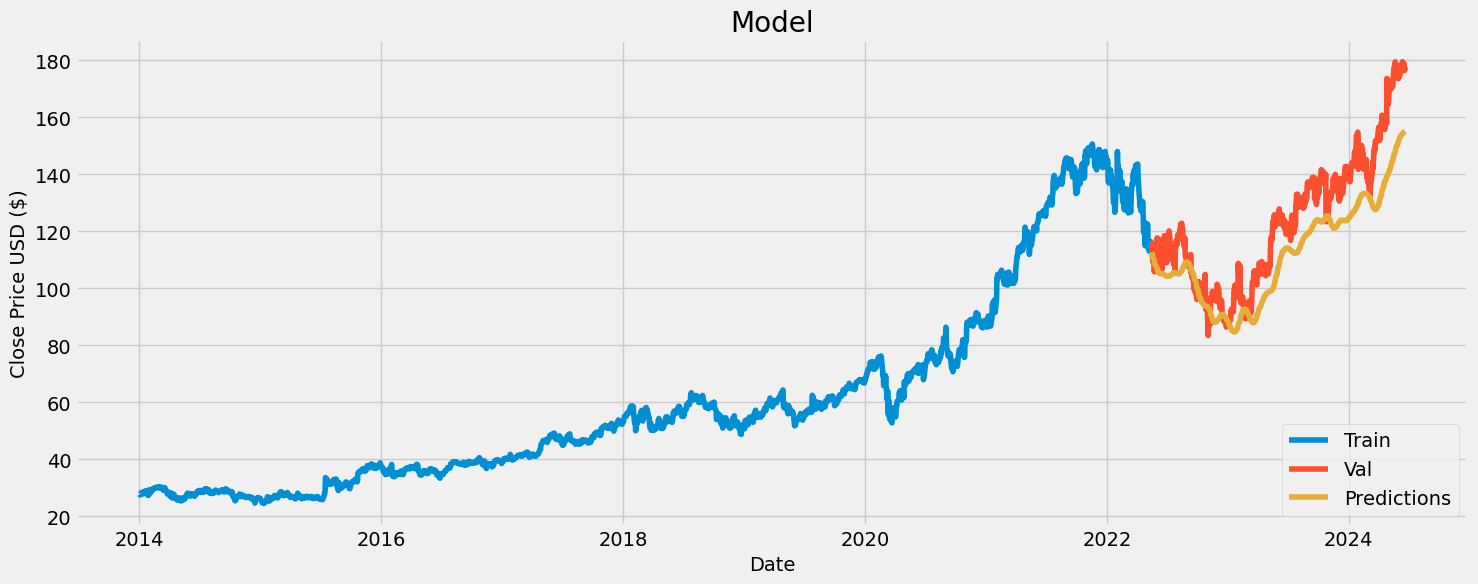

In [ ]:
'''
予測値と正解値をグラフで可視化。
茶色のラインが予測値、赤いラインが実際の株価（正解値）
'''
train = data[:training_data_len]
valid = data[training_data_len:].copy()  # .copy()メソッドを使用してDataFrameのコピーを作成
valid['LSTM_Predictions'] = predictions # <- 修正箇所

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'LSTM_Predictions']]) # <- 修正箇所
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

#<font color=fbb03b>2. LSTMを用いた株価分析②

##<font color=fbb03b>2.1 データの準備

### get_stock_data関数

- 指定されたティッカーシンボルの株価データを取得します。外部APIやデータベースからデータを取得するための関数です。

In [ ]:
def get_stock_data(tickers, start, end):
    """Retrieve historical stock data for multiple tickers."""

    """
    指定されたティッカーシンボルの株価データを取得します。

    Parameters:
    - tickers (list): 株式のティッカーシンボルのリスト
    - start (str): データ取得の開始日（例: '2020-01-01'）
    - end (str): データ取得の終了日（例: '2023-01-01'）

    Returns:
    - dict: 各ティッカーシンボルに対応するデータフレームを含む辞書
    """

    # データ取得のロジックをここに記述
    stock_data = {ticker: yf.download(ticker, start=start, end=end) for ticker in tickers}
    return stock_data

### calculate_technical_indicators関数

- 株価データにテクニカル指標を計算して追加します。ここでは移動平均（MA）、相対力指数（RSI）、ボリンジャーバンドなどが含まれます。




In [ ]:
def calculate_technical_indicators(data):
    """Calculate technical indicators including MA, RSI, and Bollinger Bands."""

    """
    株価データにテクニカル指標（移動平均、RSI、ボリンジャーバンド）を追加します。

    Parameters:
    - data (DataFrame): 株価データ

    Returns:
    - DataFrame: テクニカル指標が追加された株価データ
    """

    # テクニカル指標の計算ロジックをここに記述
    data['Short_MA'] = data['Adj Close'].rolling(window=40, min_periods=1).mean()
    data['Long_MA'] = data['Adj Close'].rolling(window=100, min_periods=1).mean()
    data['RSI'] = talib.RSI(data['Adj Close'], timeperiod=14)
    data['Upper_Band'], data['Middle_Band'], data['Lower_Band'] = talib.BBANDS(data['Adj Close'], timeperiod=20)
    return data

##<font color=fbb03b>2.2 売買シグナルの生成

### generate_signals関数

- テクニカル指標に基づいて売買シグナルを生成します。例えば、短期移動平均が長期移動平均を上回ったら買いシグナル、下回ったら売りシグナルなどを設定します。



In [ ]:
def generate_signals(data):
    """Generate trading signals based on multiple strategies."""

    """
    テクニカル指標に基づいて売買シグナルを生成します。

    Parameters:
    - data (DataFrame): テクニカル指標が追加された株価データ

    Returns:
    - DataFrame: 売買シグナルが追加された株価データ
    """

    # テクニカル指標のシグナル生成ロジックをここに記述
    data['Signal'] = 0
    # Moving average crossover strategy
    data.loc[(data['Short_MA'] > data['Long_MA']) & (data['RSI'] < 70), 'Signal'] += 1  # Buy signal
    data.loc[(data['Short_MA'] < data['Long_MA']) & (data['RSI'] > 30), 'Signal'] -= 1  # Sell signal
    # RSI strategy
    data.loc[data['RSI'] > 70, 'Signal'] -= 1  # Sell signal
    data.loc[data['RSI'] < 30, 'Signal'] += 1  # Buy signal
    # Bollinger Bands strategy
    data.loc[(data['Adj Close'] > data['Upper_Band']), 'Signal'] -= 1  # Sell signal
    data.loc[(data['Adj Close'] < data['Lower_Band']), 'Signal'] += 1  # Buy signal
    # LSTMの予測値を考慮
    data.loc[(data['LSTM_Predictions'] > data['Close'].shift(1)), 'Signal'] += 1 # LSTMが上昇トレンドと予測すれば買い
    data.loc[(data['LSTM_Predictions'] < data['Close'].shift(1)), 'Signal'] -= 1 # LSTMが下降トレンドと予測すれば売り

    # シグナルの強度で判断
    data.loc[data['Signal'] >= 2, 'Signal'] = 1  # 強い買いシグナル
    data.loc[data['Signal'] <= -2, 'Signal'] = -1 # 強い売りシグナル
    data.loc[(data['Signal'] >= -1) & (data['Signal'] <= 1), 'Signal'] = 0 # 弱いシグナルは無視

    return data

##<font color=fbb03b>2.3 ポジションサイズの計算

### calculate_position_size関数

- 各トレードのリスクに基づいてポジションサイズを計算します。トレードごとのリスク割合や初期資本を考慮して、適切なトレードサイズを計算します。



In [ ]:
def calculate_position_size(data, risk_per_trade=0.01, initial_capital=100000):
    """Calculate position size based on risk management."""

    """
    リスク管理に基づいてポジションサイズを計算します。

    Parameters:
    - data (DataFrame): 売買シグナルが追加された株価データ
    - risk_per_trade (float): トレードごとのリスク割合（初期資本に対する割合）
    - initial_capital (float): 初期資本

    Returns:
    - DataFrame: ポジションサイズが追加された株価データ
    """

    # ポジションサイズの計算ロジックをここに記述
    data['Prev_Close'] = data['Adj Close'].shift(1)
    data['TR'] = data.apply(lambda x: max(x['High'] - x['Low'], abs(x['High'] - x['Prev_Close']), abs(x['Low'] - x['Prev_Close'])), axis=1)
    data['ATR'] = data['TR'].rolling(window=14).mean()
    data['Position_Size'] = (risk_per_trade * initial_capital) / data['ATR']
    return data

##<font color=fbb03b>2.4 バックテスト

### backtest_strategy関数


- 売買シグナルに基づいてバックテストを実施します。初期資本、取引コスト、スリッページなどを考慮して、戦略のパフォーマンスを評価します。



In [ ]:
def backtest_strategy(data, initial_capital=100000, transaction_cost=0.001, slippage=0.001):
    """Backtest the strategy with risk management, transaction costs, and slippage."""

    """
    売買シグナルに基づいてバックテストを行います。

    Parameters:
    - data (DataFrame): 売買シグナルが追加された株価データ
    - initial_capital (float): 初期資本
    - transaction_cost (float): 取引コスト（例: 0.001）
    - slippage (float): スリッページ（例: 0.001）

    Returns:
    - DataFrame: バックテストの結果
    """

    # バックテストのロジックをここに記述
    data['Return'] = data['Adj Close'].pct_change()
    data['Strategy_Return'] = data['Signal'].shift(1) * data['Return']
    # Subtract transaction costs and slippage
    data['Transaction_Cost'] = data['Signal'].diff().abs() * transaction_cost
    data['Slippage_Cost'] = data['Signal'].diff().abs() * slippage
    data['Strategy_Return'] = data['Strategy_Return'] - data['Transaction_Cost'] - data['Slippage_Cost']
    # Calculate portfolio value
    data['Portfolio'] = initial_capital * (1 + data['Strategy_Return']).cumprod()
    # Calculate drawdown
    data['Cumulative_Max'] = data['Portfolio'].cummax()
    data['Drawdown'] = data['Portfolio'] - data['Cumulative_Max']
    max_drawdown = data['Drawdown'].min()
    # Annualize Sharpe ratio
    annual_sharpe_ratio = (data['Strategy_Return'].mean() / data['Strategy_Return'].std()) * np.sqrt(252)
    return data, annual_sharpe_ratio, max_drawdown

### optimize_parameters関数

- パラメータの最適化を行います。異なるテクニカル指標のパラメータを試して、最適な組み合わせを見つけ、シャープレシオを最大化するように最適化します。



In [ ]:
def optimize_parameters(data, initial_capital=100000, transaction_cost=0.001, slippage=0.001):
    """Optimize strategy parameters using Bayesian Optimization."""

    """
    パラメータの最適化を行います。

    Parameters:
    - data (DataFrame): 株価データ
    - initial_capital (float): 初期資本
    - transaction_cost (float): 取引コスト（例: 0.001）
    - slippage (float): スリッページ（例: 0.001）

    Returns:
    - dict: 最適化されたパラメータ
    - float: 最適化されたシャープレシオ
    """

    # パラメータ最適化のロジックをここに記述
    def target_function(short_window, long_window, rsi_period, bb_period):
        data_copy = data.copy()
        data_copy['Short_MA'] = data_copy['Adj Close'].rolling(window=int(short_window), min_periods=1).mean()
        data_copy['Long_MA'] = data_copy['Adj Close'].rolling(window=int(long_window), min_periods=1).mean()
        data_copy['RSI'] = talib.RSI(data_copy['Adj Close'], timeperiod=int(rsi_period))
        data_copy['Upper_Band'], data_copy['Middle_Band'], data_copy['Lower_Band'] = talib.BBANDS(data_copy['Adj Close'], timeperiod=int(bb_period))
        strategy_data = generate_signals(data_copy)
        strategy_data = calculate_position_size(strategy_data)
        backtest_results, annual_sharpe_ratio, _ = backtest_strategy(strategy_data, initial_capital, transaction_cost, slippage)
        return annual_sharpe_ratio

    optimizer = BayesianOptimization(
        f=target_function,
        pbounds={
            'short_window': (5, 50),
            'long_window': (50, 200),
            'rsi_period': (5, 50),
            'bb_period': (10, 50)
        },
        random_state=1
    )
    optimizer.maximize(init_points=10, n_iter=30)
    best_params = optimizer.max['params']
    best_params = {k: int(v) for k, v in best_params.items()}
    best_sharpe = optimizer.max['target']
    return best_params, best_sharpe

### backtest_with_optimized_params関数

- 最適化されたパラメータを使用してバックテストを実施します。これにより、最適化された戦略のパフォーマンスを評価します。

In [ ]:
def backtest_with_optimized_params(data, optimized_params, initial_capital=100000, transaction_cost=0.001, slippage=0.001):
    """Backtest the strategy with optimized parameters."""

    """
    最適化されたパラメータを使用してバックテストを行います。

    Parameters:
    - data (DataFrame): 株価データ
    - optimized_params (dict): 最適化されたパラメータ
    - initial_capital (float): 初期資本
    - transaction_cost (float): 取引コスト（例: 0.001）
    - slippage (float): スリッページ（例: 0.001）

    Returns:
    - DataFrame: バックテストの結果
    - float: 年率換算シャープレシオ
    - float: 最大ドローダウン
    """

    # 最適化パラメータを使用したバックテストのロジックをここに記述
    data_copy = data.copy()
    data_copy['Short_MA'] = data_copy['Adj Close'].rolling(window=optimized_params['short_window'], min_periods=1).mean()
    data_copy['Long_MA'] = data_copy['Adj Close'].rolling(window=optimized_params['long_window'], min_periods=1).mean()
    data_copy['RSI'] = talib.RSI(data_copy['Adj Close'], timeperiod=optimized_params['rsi_period'])
    data_copy['Upper_Band'], data_copy['Middle_Band'], data_copy['Lower_Band'] = talib.BBANDS(data_copy['Adj Close'], timeperiod=optimized_params['bb_period'])
    strategy_data = generate_signals(data_copy)
    strategy_data = calculate_position_size(strategy_data)
    backtest_results, annual_sharpe_ratio, max_drawdown = backtest_strategy(strategy_data, initial_capital, transaction_cost, slippage)
    return backtest_results, annual_sharpe_ratio, max_drawdown

##<font color=fbb03b>2.5 バックテストの結果を可視化

### plot_backtest_results関数

- バックテスト結果を視覚的に表示します。ポートフォリオの価値やドローダウンの推移をプロットします。



In [ ]:
def plot_backtest_results(data):
    """Plot portfolio value and drawdown."""

    """
    バックテスト結果をプロットします。

    Parameters:
    - data (DataFrame): バックテスト結果

    Returns:
    - None
    """

    # プロットのロジックをここに記述
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    # Plot portfolio value
    ax[0].plot(data['Portfolio'], label='Portfolio Value')
    ax[0].set_title('Portfolio Value Over Time')
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Portfolio Value')
    ax[0].legend()
    # Plot drawdown
    ax[1].plot(data['Drawdown'], label='Drawdown', color='red')
    ax[1].set_title('Drawdown Over Time')
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Drawdown')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

※上記の各関数を組み合わせて株価データの取得から戦略の最適化と評価までの一連のプロセスを実行できます。

※各関数はモジュール化されており、個別にテストや改良を行うことが容易です。

##<font color=fbb03b>2.6 使用例

In [ ]:
# Example usage
tickers = ['GOOG']
start_date = '2014-01-01'
end_date = datetime.now()

# データの取得
stock_data = get_stock_data(tickers, start_date, end_date)
"""
指定されたティッカーシンボルの株価データを取得します。tickersには株式のシンボル（例：'6758.T'など）がリストで含まれています。
日本株の例としてトヨタ（7203.T）、ソニー（6758.T）、ソフトバンク（9984.T）のティッカーシンボルがあります。
この例ではgoogle(GOOG)を使用しています。
"""

[*********************100%%**********************]  1 of 1 completed


### 結果を出力

|   iter    |  target   | bb_period | long_w... | rsi_pe... | short_... |
-------------------------------------------------------------------------
| 1         | 0.2315    | 26.68     | 158.0     | 5.005     | 18.6      |
| 2         | 0.09107   | 15.87     | 63.85     | 13.38     | 20.55     |
| 3         | 0.2249    | 25.87     | 130.8     | 23.86     | 35.83     |
| 4         | 0.2346    | 18.18     | 181.7     | 6.232     | 35.17     |
| 5         | 0.2475    | 26.69     | 133.8     | 11.32     | 13.91     |
| 6         | 0.181     | 42.03     | 195.2     | 19.1      | 36.15     |
| 7         | 0.1437    | 45.06     | 184.2     | 8.827     | 6.757     |
| 8         | 0.255     | 16.79     | 181.7     | 9.426     | 23.95     |
| 9         | 0.2341    | 48.32     | 130.0     | 36.13     | 19.2      |
| 10        | -0.03598  | 37.46     | 175.2     | 5.823     | 38.76     |
| 11        | 0.226     | 16.9      | 182.5     | 9.531     | 22.67     |
| 12        | 0.3172    | 13.63     | 

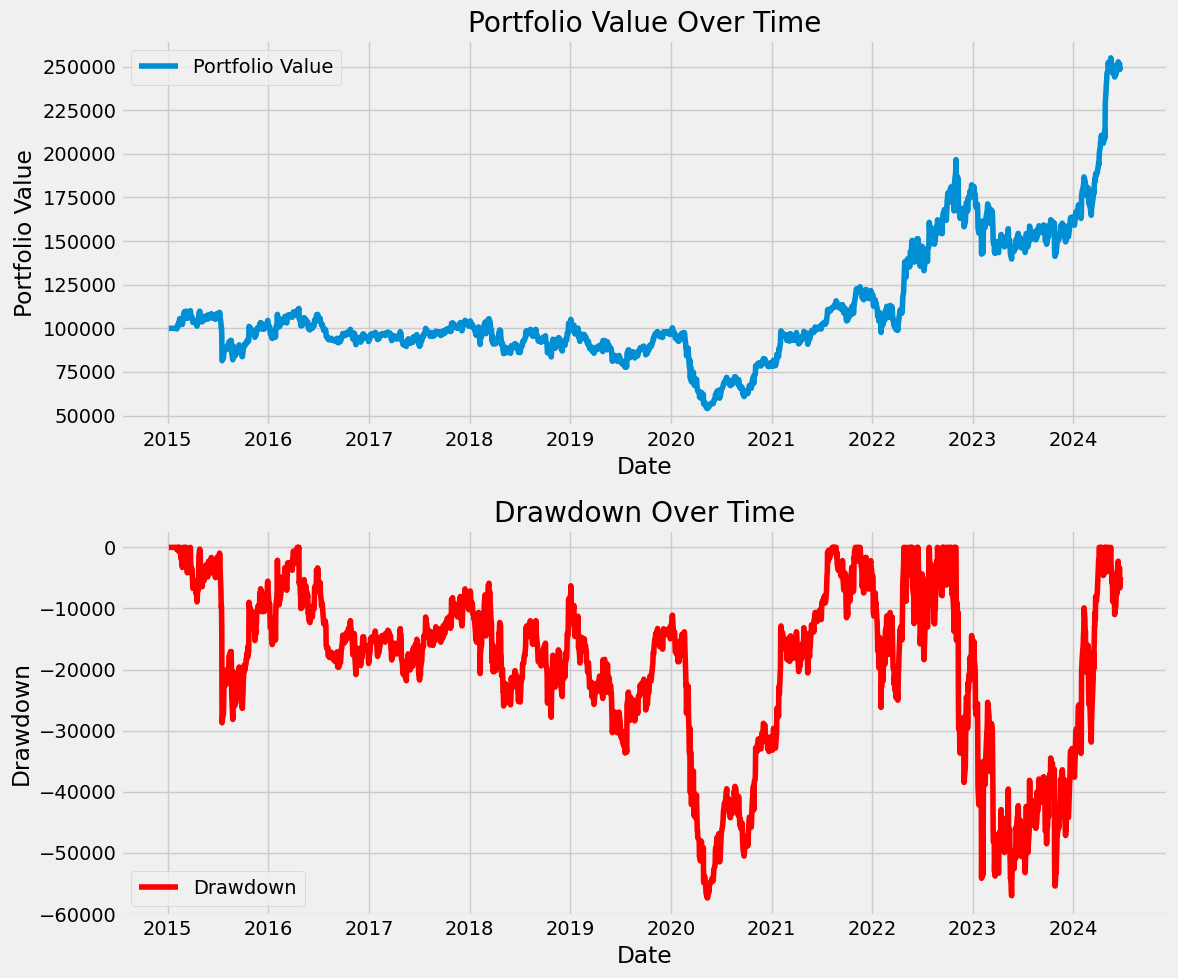

In [ ]:
for ticker, data in stock_data.items():
    # Calculate technical indicators（テクニカル指標の計算）
    # 各ティッカーの株価データに対して、移動平均（MA）、相対力指数（RSI）、ボリンジャーバンド、 LSTMモデルの予測結果を計算します。
    stock_data[ticker] = calculate_technical_indicators(data)

    # --- 修正箇所: LSTMの予測結果をdataに追加 ---
    data = pd.merge(data, valid[['LSTM_Predictions']], left_index=True, right_index=True, how='left')

    # Optimize parameters（パラメータの最適化）
    """
    ベイズ最適化を使用して、各ティッカーの最適なパラメータ（短期移動平均期間、長期移動平均期間、RSI期間、ボリンジャーバンド期間）を見つけます。
    最適なパラメータと最適化されたシャープレシオを出力します。
    """
    optimized_params, best_sharpe = optimize_parameters(stock_data[ticker]) # <- dataはLSTM予測値を含んでいる
    print(f"Best parameters for {ticker}: {optimized_params}")
    print(f"Best Sharpe ratio for {ticker}: {best_sharpe:.4f}")

    # Backtest with optimized parameters(最適化されたパラメータでバックテスト)
    """
    最適化されたパラメータを使用してバックテストを行います。
    最終ポートフォリオの価値、年率換算のシャープレシオ、最大ドローダウン（損失の最大値）を出力します。
    """
    # Backtest with optimized parameters and LSTM predictions
    backtest_results, annual_sharpe_ratio, max_drawdown = backtest_with_optimized_params(data, optimized_params)
    final_portfolio_value = backtest_results['Portfolio'].iloc[-1]
    print(f"Final Portfolio Value for {ticker} with Optimized Parameters: ${final_portfolio_value:.2f}")
    print(f"Annualized Sharpe Ratio for {ticker}: {annual_sharpe_ratio:.4f}")
    print(f"Maximum Drawdown for {ticker}: ${max_drawdown:.2f}")

    # Plotting the results（結果のプロット）：ポートフォリオの価値とドローダウンのグラフを表示します。
    plot_backtest_results(backtest_results)

### 出力内容の解説
**1. 最適パラメータの出力**

- 内容：各ティッカーについて、ベイズ最適化により見つけた最適なパラメータが表示されます。

- 例：Best parameters for 6758.T: {'bb_period': 50, 'long_window': 176, 'rsi_period': 50, 'short_window': 50}

- 詳細：

 - bb_period：ボリンジャーバンドの計算に使用する期間

 - long_window：長期移動平均の期間

 - rsi_period：RSIの計算に使用する期間

 - short_window：短期移動平均の期間

 - これらのパラメータが最適化されることで、投資戦略のパフォーマンスが最大化されます。

**2. 最適化されたシャープレシオの出力**

- 内容：最適化されたパラメータで計算されたシャープレシオが表示されます。

- 例：Best Sharpe ratio for 6758.T: 0.6398

- 詳細：

 - シャープレシオは、リスク調整後のリターンを測定する指標です。

 - 高いシャープレシオは、高リターンを低リスクで達成していることを示します。

**3. 最終ポートフォリオ価値の出力**

- 内容：バックテストの終了時点でのポートフォリオの価値が表示されます。

- 例：Final Portfolio Value for 6758.T with Optimized Parameters: $324464.38

- 詳細：

 - バックテスト期間の終わりにおけるポートフォリオの価値を示します。これにより、投資戦略の実績を評価できます。

**4. 年率換算シャープレシオの出力**

- 内容：最適化されたパラメータで計算された年率換算のシャープレシオが表示されます。

- 例：Annualized Sharpe Ratio for 6758.T: 0.6398

- 詳細：

 - シャープレシオを年率換算した値です。

 - 年間を通じてのリスク調整後のリターンを評価するために使用されます。


**5. 最大ドローダウンの出力**

- 内容：バックテスト期間中の最大ドローダウン（損失の最大値）が表示されます。

- 例：Maximum Drawdown for 6758.T: $-113576.30

- 詳細：

 - ドローダウンはポートフォリオが過去のピークからどれだけ減少したかを示します。

 - 最大ドローダウンは、投資戦略のリスクを評価するための重要な指標です。

 - ドローダウンの値が小さいほど、投資戦略が安定していることを示します。

###グラフの読み方
**1. Portfolio Value Over Time**

- 横軸（X軸）：時間（日付）

- 縦軸（Y軸）：ポートフォリオの価値

【解釈】
- このグラフはバックテスト期間中のポートフォリオの価値の推移を示しています。
ポートフォリオがどのように成長または減少したかを視覚的に確認できます。

- ポートフォリオが順調に成長している場合は、グラフは右肩上がりになります。

- 一方、ポートフォリオが損失を被っている場合は、グラフは左肩下がりになります。

- グラフの傾斜が急であれば、ポートフォリオの価値が短期間で大きく変化したことを示します。

- グラフの曲線に波形が見られる場合は、ポートフォリオの価値が変動しながら推移したことを示します。

**2. Drawdown Over Time**

- 横軸（X軸）：時間（日付）

- 縦軸（Y軸）：ドローダウンの値

【解釈】

- このグラフはバックテスト期間中のドローダウン（損失）の推移を示しています。
ドローダウンが大きくなる時期や、最大の損失が発生した時期を視覚的に確認できます。

- ドローダウンが大きくなる時期は、ポートフォリオが大きな損失を被った時期であることを示します。

- グラフの曲線に谷が見られる場合は、ポートフォリオが大きな損失を被った時期であることを示します。

- ドローダウンの値が小さいほど、ポートフォリオのリスクが低いことを示します。

- 最大ドローダウン（最大の谷の深さ）は、ポートフォリオがどれだけの損失を経験したかを示し、投資戦略のリスクを評価するために重要な指標となります。